In [3]:
# import system libs
import os
import time

# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score

In [4]:
# import Deep learning Libraries
import setuptools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
#ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
        
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
    
    def dataFrame(self, files, labels):
        Fseries = pd.Series(files, name = 'filepaths')
        Lseries = pd.Series(labels, name = 'labels')
        return pd.concat([Fseries, Lseries], axis = 1)
    
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42,
                                               stratify = strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size = 0.5, shuffle = True,
                                              random_state = 42, stratify=strat)
        return trainData, validData, testData

In [35]:
dataDir = "./data/dataset/"
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

- keras의 ImageDataGenerator는 확률이 랜덤

In [36]:
# reading the dataset
train_data

,filepaths,labels
3778,./data/dataset/normal\2996_right.jpg,normal
2505,./data/dataset/glaucoma\Glaucoma_064.png,glaucoma
3709,./data/dataset/normal\2908_left.jpg,normal
567,./data/dataset/cataract\_196_4818116.jpg,cataract
3501,./data/dataset/normal\2690_right.jpg,normal
...,...,...
260,./data/dataset/cataract\2282_right.jpg,cataract
1297,./data/dataset/diabetic_retinopathy\10386_righ...,diabetic_retinopathy
500,./data/dataset/cataract\_161_3798587.jpg,cataract
846,./data/dataset/cataract\_352_2938767.jpg,cataract


### data augmentation 

In [40]:
def augment_data(train_df, valid_df, test_df, batch_size = 32):
    img_size = (256, 256)
    channels = 3
    color = 'rgb'
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 30,
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range=[0.5, 1.5])
    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col = 'filepaths',
        y_col = 'labels',
        target_size = img_size,
        color_made = color,
        batch_size = batch_size,
        shuffle = True,
        class_mode = 'categorical')
    
    print('Shape of augemented training images:', train_generator.image_shape)
    
    valid_generator = valid_test_datagen.flow_from_dataframe(
        valid_df,
        x_col = 'filepaths',
        y_col = 'labels',
        target_size = img_size,
        color_mode = color,
        batch_size = batch_size,
        shuffle = True,
        class_mode = 'categorical')
    
    print("Shape of validation images:", valid_generator.image_shape)
    
    test_generator = valid_test_datagen.flow_from_dataframe(
        test_df,
        x_col = 'filepaths',
        y_col = 'labels',
        target_size = img_size,
        color_mode = color,
        batch_size = batch_size,
        shuffle = False,
        class_mode = 'categorical')
    
    print("Shape of test images:", test_generator.image_shape)
    
    return train_generator, valid_generator, test_generator

train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augemented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


### Display Augmented images

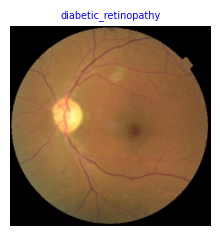

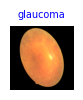

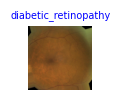

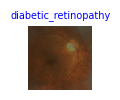

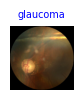

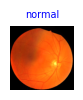

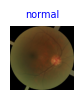

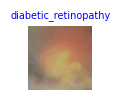

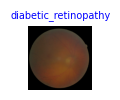

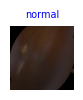

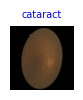

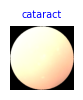

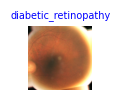

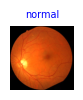

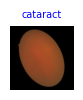

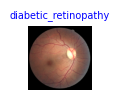

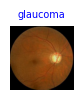

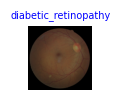

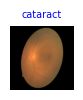

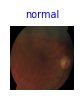

In [41]:
def show_images(gen):
    
    # defines dictionary {'class' : index}
    g_dict = gen.class_indices
    # defines list of dictionary's keys (classes), classes names ; string
    classes = list(g_dict.keys())
    # get a batch size samples from the generator
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize = (15, 17))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color = 'blue', fontsize = 7)
        plt.axis('off')
        plt.show()
        
show_images(train_augmented)

In [43]:
from tensorflow.keras.applications import EfficientNetB3
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

### 모델 생성

In [45]:
classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights = 'imagenet', include_top = False, input_shape=(256, 256,3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)

predictions = Dense(classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

### fit the model

In [46]:
history = model.fit(
    train_augmented,
    epochs = 10, # 더 돌려도 됨
    validation_data = valid_augmented,)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 451s 4s/step - accuracy: 0.6810 - loss: 0.7555 - val_accuracy: 0.6919 - val_loss: 0.7661
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.7786 - loss: 0.5324 - val_accuracy: 0.7488 - val_loss: 0.6279
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.8045 - loss: 0.4967 - val_accuracy: 0.7749 - val_loss: 0.6537
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2068s 20s/step - accuracy: 0.8195 - loss: 0.4390 - val_accuracy: 0.7512 - val_loss: 0.6744
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.8421 - loss: 0.4108 - val_accuracy: 0.8152 - val_loss: 0.5702
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.8333 - loss: 0.4112 - val_accuracy: 0.8152 - val_loss: 0.5347
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8581 - loss: 0.3748 - val_accuracy: 0.8009 - val_loss: 0.5158
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.8595 - loss: 0.3595 - val_ac